# Introduction

### Competition: [Titanic Kaggle](https://www.kaggle.com/c/titanic/overview)

This is notebook contains a simple data science project framework, for learning and portfolio construction purposes.

# Libs

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Embedding,  Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.data import Dataset
from tensorflow import keras

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import QuantileTransformer,  KBinsDiscretizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import metrics

import matplotlib.pyplot as plt

import optuna
from optuna.visualization import plot_contour, plot_edf, plot_intermediate_values, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_slice

# Load Dataset

This step we simply get our data to our working environment. Because we are not dealing with live data, a simple pandas usage is enough.

In [2]:
%%time

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

Wall time: 22 ms


# Exploratory Data Analysis

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Checking if Pclass has any effect on survival rate

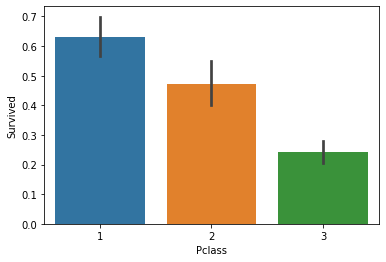

In [4]:
sns.barplot(x="Pclass", y="Survived", data=train);

Here we can see that Pclass is an important variable

### Checking Sex and Embarked

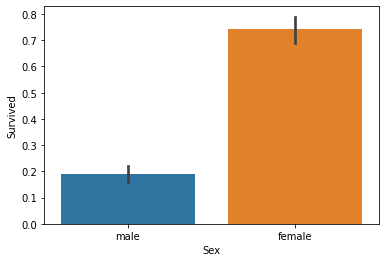

In [5]:
sns.barplot(x="Sex", y="Survived", data=train);

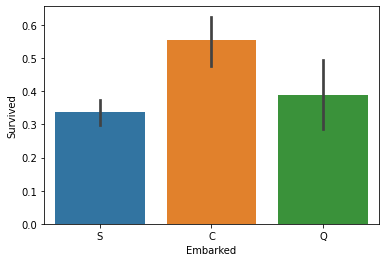

In [6]:
sns.barplot(x="Embarked", y="Survived", data=train);

We can see that the survival rate between females and males are most discrepant, and the *Embarked* variable has some effect as well.

- [x] Pclass
- [ ] Name
- [x] Sex
- [ ] Age
- [ ] SibSp
- [ ] Parch
- [ ] Ticket
- [ ] Fare
- [ ] Cabin
- [x] Embarked

## Let's verify the rest of categorical variables (Cabin, Name, Ticket)

### First, the Cabin variable

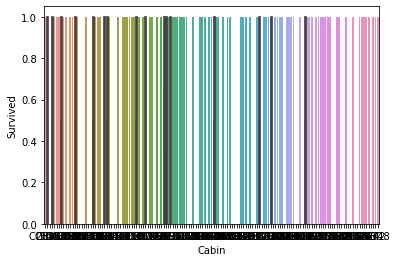

In [7]:
sns.barplot(x="Cabin", y="Survived", data=train);

We can't really use it this way, so let's change it a little:
Let's test three hipothesis:
- The letter is important;
- The number is important;
- Having it as missing or not is important.

In [8]:
train.loc[train['Cabin'].isna(), 'Cabin'] = 'missing'
cabin_letters = [s[0] for s in train['Cabin']]

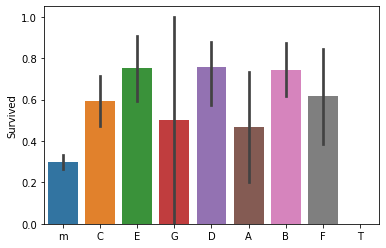

In [9]:
sns.barplot(x= cabin_letters, y=train["Survived"]);

Here we can see that the missing values don't really tell us anything, as it's mean is around the overall survival rate.

Overall, most of the error bars are too big for us to consider that the letter has anything to do with the survival rate. However, we will consider the C, E, D, B letters as they are statiscally different than the overall mean.

Before moving on, let's see if we can embed them in one variable.

In [10]:
for letter in range(len(cabin_letters)):
    if cabin_letters[letter] in ['C', 'E', 'D', 'B']:
        cabin_letters[letter] = 'group1'

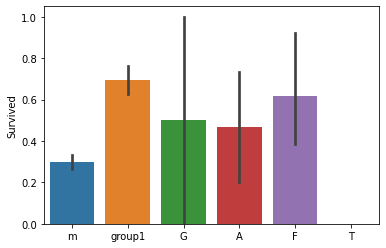

In [11]:
sns.barplot(x = cabin_letters, y = train["Survived"]);

Is the cabin number important?

In [12]:
cabin_numbers = [s.split()[0][1:] for s in train['Cabin']]
for i in range(len(cabin_numbers)):
    try:
        cabin_numbers[i] = int(cabin_numbers[i])
    except Exception:
        cabin_numbers[i] = np.nan

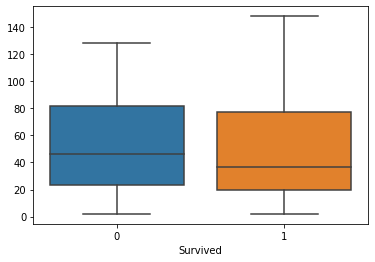

In [13]:
sns.boxplot(x = train["Survived"], y = cabin_numbers);

With this we can conclude that the number is not relevant!
- [x] The letter is important (**Important**);
- [x] The number is important (**Not Important**);
- [x] Having it as missing or not is important (**Not Important**).

### Next, the *Name* variable

In [14]:
len(train['Name'].unique())

891

Here we can see that every name here is unique, so we have to transform it a bit. 

The hipothesis tested is that the title of each name is relevant to predict the survival rate.

In [15]:
name_and_title = [name.split(", ")[1] for name in train['Name']]
title = [name.split(".")[0] for name in name_and_title]
print(len(title))

891


In [16]:
print(len(np.unique(title)))
np.unique(title)

17


array(['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master',
       'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir',
       'the Countess'], dtype='<U12')

In [17]:
pd.Series(title).value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Sir               1
Mme               1
Don               1
Lady              1
the Countess      1
Ms                1
Jonkheer          1
Capt              1
dtype: int64

Let's only consider the titles: Mr, Miss, Mrs and Master; as we don't have enough observations from the others

In [18]:
for i in range(len(title)):
    if title[i] not in ['Mr', 'Miss', 'Mrs', 'Master']:
        title[i] = 'Other'        

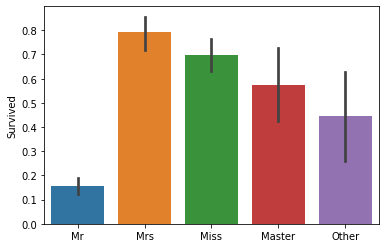

In [40]:
train['Name'] = title
sns.barplot(x = title, y = train["Survived"]);

The *Mrs* title is relevant, however it is probably highly correlated with the *Sex* variable.

Something intereting is the relevancy of the *Master* title, that probably has information about the economical power of the person.

### Lastly, the Ticket variable

In [20]:
train['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

Here we will test only one hipothesis:
- The letters have relevant information

In [21]:
tickets = [s.split()[0] for s in train['Ticket']]
for i in range(len(tickets)):
    try:
        int(tickets[i])
        tickets[i] = "number"
    except:
        tickets[i] = "Letter"

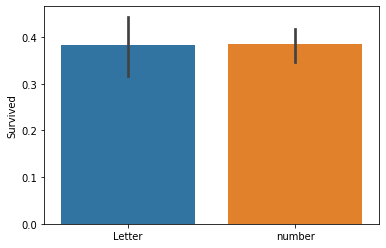

In [22]:
sns.barplot(x = tickets, y = train["Survived"]);

We can conclude here that the letter in the ticket variable most likely has not any relevant information.

- [x] Pclass
- [x] Name
- [x] Sex
- [ ] Age
- [ ] SibSp
- [ ] Parch
- [x] Ticket
- [ ] Fare
- [x] Cabin
- [x] Embarked

## Now, for the numerical variables (*Age*,	*SibSp*, *Parch*, *Fare*)

### Age

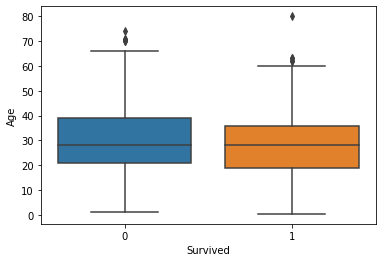

In [23]:
sns.boxplot(x = train["Survived"], y = train['Age']);

It looks like the average age does not differ when comparing the survived and not survived people.

### SibSp

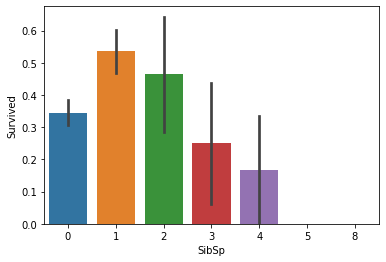

In [24]:
sns.barplot(x = train['SibSp'], y = train["Survived"]);

Only when SibSp = 1 that we have a relevant information.

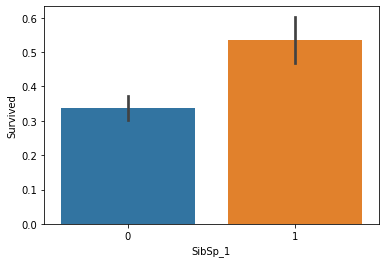

In [53]:
train['SibSp_1'] = (train['SibSp'] == 1).astype(int)
sns.barplot(x = train['SibSp_1'], y = train["Survived"]);

### Parch

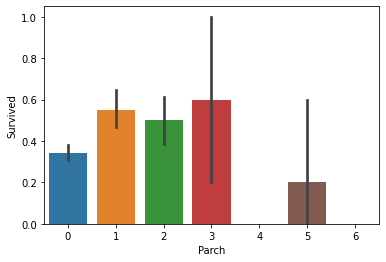

In [26]:
sns.barplot(x = train['Parch'], y = train["Survived"]);

We can have better predictions when Parch = 1 or 2

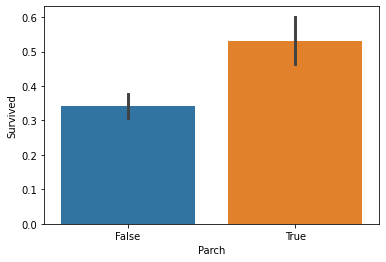

In [54]:
sns.barplot(x = parch_1_2, y = train["Survived"]);
train['parch_1_or_2'] = np.logical_or(train['Parch'] == 1, train['Parch'] == 2).astype(int)
sns.barplot(x = np.logical_or(train['Parch'] == 1, train['Parch'] == 2), y = train["Survived"]);

### Parch + SibSp

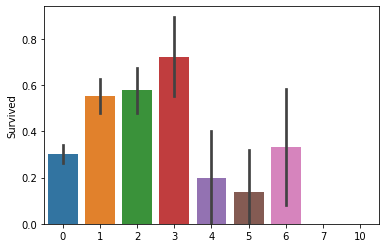

In [29]:
sns.barplot(x = train['Parch'] + train['SibSp'], y = train["Survived"]);

Here we can see that from 4 Parch + SipSp, the survival rate decreases, so we will create a dummy variable for <4 relatives.

In [56]:
train

,PassengerId,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,...,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Miss,Mr,Mrs,parch_1_or_2,SibSp_1
0,1,0,22.0,1,0,A/5 21171,7.2500,missing,0,0,...,0,1,0,0,1,0,1,0,0,1
1,2,1,38.0,1,0,PC 17599,71.2833,C85,1,0,...,1,0,1,0,0,0,0,1,0,1
2,3,1,26.0,0,0,STON/O2. 3101282,7.9250,missing,0,0,...,1,0,0,0,1,1,0,0,0,0
3,4,1,35.0,1,0,113803,53.1000,C123,1,0,...,1,0,0,0,1,0,0,1,0,1
4,5,0,35.0,0,0,373450,8.0500,missing,0,0,...,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,27.0,0,0,211536,13.0000,missing,0,1,...,0,1,0,0,1,0,0,0,0,0
887,888,1,19.0,0,0,112053,30.0000,B42,1,0,...,1,0,0,0,1,1,0,0,0,0
888,889,0,NaN,1,2,W./C. 6607,23.4500,missing,0,0,...,1,0,0,0,1,1,0,0,1,1
889,890,1,26.0,0,0,111369,30.0000,C148,1,0,...,0,1,1,0,0,0,1,0,0,0


In [30]:
parch_sibsp_1 = []
for i in range(len(train)):
    if train.loc[i, 'Parch'] + train.loc[i, 'SibSp'] < 4:
        parch_sibsp_1.append(1)
        
    else:
        parch_sibsp_1.append(0)

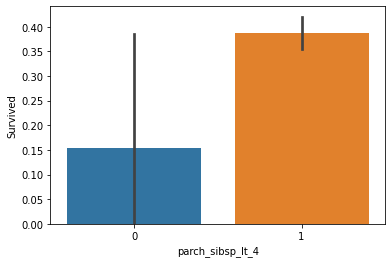

In [57]:
train['parch_sibsp_lt_4'] = ((train['Parch'] + train['SibSp']) < 4).astype(int)
sns.barplot(x = train['parch_sibsp_lt_4'], y = train["Survived"]);

### Fare

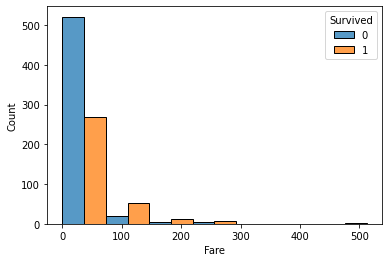

In [32]:
sns.histplot(multiple = 'dodge', x = train['Fare'], hue = train["Survived"], bins = 7);

Higher fares -> higher survival rates

- [x] Pclass
- [x] Name
- [x] Sex
- [x] Age
- [x] SibSp
- [x] Parch
- [x] Ticket
- [x] Fare
- [x] Cabin
- [x] Embarked

# Variable Selection
Using the EDA's results, the variable selection step will be manual.
For our model, we will initially use the variables:
* Pclass
* Sex
* Embarked
* Cabin (Dummy for when C, E, D or B)
* Name (Mr, Mrs, Miss, Master)
* SibSp (when equals 1)
* Patch (when equals 1 or 2)
* SibSp + Parch (when equals 4 or less)
* Fare

# Preprocessing

## Dealing with *Missings*

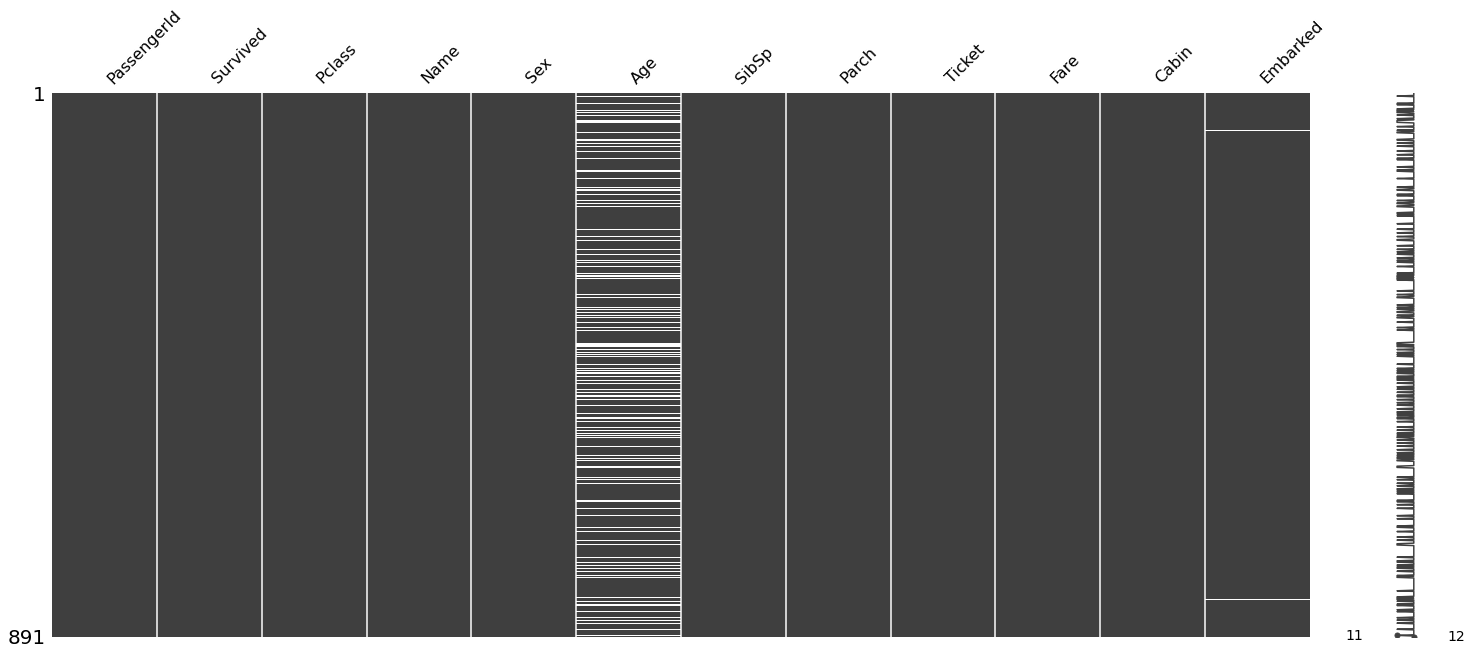

In [33]:
import missingno as msno
msno.matrix(train);

We will use the mode value for the Embarked variable. As the Age variable will not be used, we will not treat it.

In [34]:
train.loc[train.isna()['Embarked'],:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [35]:
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

## One-hot Encoding

In [37]:
train = pd.get_dummies(train, columns = ['Pclass', 'Sex', 'Embarked'])

In [43]:
train = pd.concat([train, pd.get_dummies(train['Name']).filter(['Miss', 'Mr', 'Mrs', 'Master'])], axis = 1)
train.drop('Name', axis = 1, inplace = True)

# test = pd.concat([test, pd.get_dummies(test['Name']).filter(['Miss', 'Mr', 'Mrs', 'Ms'])], axis = 1)
# test.drop('Name', axis = 1, inplace = True)

In [50]:
train

,PassengerId,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Miss,Mr,Mrs,parch_1_or_2
0,1,0,22.0,1,0,A/5 21171,7.2500,missing,0,0,1,0,1,0,0,1,0,1,0,0
1,2,1,38.0,1,0,PC 17599,71.2833,C85,1,0,0,1,0,1,0,0,0,0,1,0
2,3,1,26.0,0,0,STON/O2. 3101282,7.9250,missing,0,0,1,1,0,0,0,1,1,0,0,0
3,4,1,35.0,1,0,113803,53.1000,C123,1,0,0,1,0,0,0,1,0,0,1,0
4,5,0,35.0,0,0,373450,8.0500,missing,0,0,1,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,27.0,0,0,211536,13.0000,missing,0,1,0,0,1,0,0,1,0,0,0,0
887,888,1,19.0,0,0,112053,30.0000,B42,1,0,0,1,0,0,0,1,1,0,0,0
888,889,0,NaN,1,2,W./C. 6607,23.4500,missing,0,0,1,1,0,0,0,1,1,0,0,1
889,890,1,26.0,0,0,111369,30.0000,C148,1,0,0,0,1,1,0,0,0,1,0,0


In [3]:
%%time

train['Survived'] = train['Survived'].astype(str)

train['n_missing'] = train.isna().sum(axis=1)
test['n_missing'] = test.isna().sum(axis=1)

test['Pclass']= test['Pclass'].astype(str)
test['Pclass']= test['Pclass'].astype(str)

features = [col for col in train.columns if col not in ['Survived', 'PassengerId']]

Wall time: 5.99 ms


### Dealing with the Ticket feature

In [9]:
train['Ticket'][0:5]

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

**One hypothesis we can make** is that the numbers don't contain any relevant information and the prefix may contain relevant information.

In [10]:
ticket_prefixes = [ticket.split()[0] for ticket in train['Ticket']]
ticket_prefixes[0:5]

['A/5', 'PC', 'STON/O2.', '113803', '373450']

In [11]:
for i in range(len(ticket_prefixes)):
    try: 
        int(ticket_prefixes[i])
        ticket_prefixes[i] = "number_only"
    
    except Exception:
        pass

In [12]:
ticket_prefixes[0:5]

['A/5', 'PC', 'STON/O2.', 'number_only', 'number_only']

In [13]:
print(len(np.unique(ticket_prefixes)))
np.unique(ticket_prefixes)

44


array(['A./5.', 'A.5.', 'A/4', 'A/4.', 'A/5', 'A/5.', 'A/S', 'A4.', 'C',
       'C.A.', 'C.A./SOTON', 'CA', 'CA.', 'F.C.', 'F.C.C.', 'Fa', 'LINE',
       'P/PP', 'PC', 'PP', 'S.C./A.4.', 'S.C./PARIS', 'S.O./P.P.',
       'S.O.C.', 'S.O.P.', 'S.P.', 'S.W./PP', 'SC', 'SC/AH', 'SC/PARIS',
       'SC/Paris', 'SCO/W', 'SO/C', 'SOTON/O.Q.', 'SOTON/O2', 'SOTON/OQ',
       'STON/O', 'STON/O2.', 'SW/PP', 'W./C.', 'W.E.P.', 'W/C', 'WE/P',
       'number_only'], dtype='<U11')

In [14]:
ticket_prefixes = [s.replace(".", "") for s in ticket_prefixes]
ticket_prefixes = [s.replace(",", "") for s in ticket_prefixes]
ticket_prefixes = [s.upper() for s in ticket_prefixes]

In [15]:
print(len(np.unique(ticket_prefixes)))
np.unique(ticket_prefixes)

34


array(['A/4', 'A/5', 'A/S', 'A4', 'A5', 'C', 'CA', 'CA/SOTON', 'FA', 'FC',
       'FCC', 'LINE', 'NUMBER_ONLY', 'P/PP', 'PC', 'PP', 'SC', 'SC/A4',
       'SC/AH', 'SC/PARIS', 'SCO/W', 'SO/C', 'SO/PP', 'SOC', 'SOP',
       'SOTON/O2', 'SOTON/OQ', 'SP', 'STON/O', 'STON/O2', 'SW/PP', 'W/C',
       'WE/P', 'WEP'], dtype='<U11')

In [16]:
test_ticket_prefixes = [ticket.split()[0] for ticket in test['Ticket']]
for i in range(len(test_ticket_prefixes)):
    try: 
        int(test_ticket_prefixes[i])
        test_ticket_prefixes[i] = "number_only"
    
    except Exception:
        pass

test_ticket_prefixes = [s.replace(".", "") for s in test_ticket_prefixes]
test_ticket_prefixes = [s.replace(",", "") for s in test_ticket_prefixes]
test_ticket_prefixes = [s.upper() for s in test_ticket_prefixes]

In [17]:
train['Ticket'] = ticket_prefixes
test['Ticket'] = test_ticket_prefixes

In [18]:
train = pd.concat([train, pd.get_dummies(train['Ticket']).filter(['PC', 'CA', 'NUMBER_ONLY'])], axis = 1)
train.drop('Ticket', axis = 1, inplace = True)

test = pd.concat([test, pd.get_dummies(test['Ticket']).filter(['PC', 'CA', 'NUMBER_ONLY'])], axis = 1)
test.drop('Ticket', axis = 1, inplace = True)

### Dealing with the Cabin feature

Same as the *Ticket* feature. I will assume that the number doesn't have relevant information.

In [19]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [20]:
cabin_prefix = []
for i in range(len(train['Cabin'])):
    try:
        cabin_prefix.append(train['Cabin'][i][0: 1: 1])
    
    except:
        cabin_prefix.append(train['Cabin'][i])        

In [21]:
np.unique(cabin_prefix)

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'nan'], dtype='<U32')

In [22]:
cabin_test_prefix = []
for i in range(len(test['Cabin'])):
    try:
        cabin_test_prefix.append(test['Cabin'][i][0: 1: 1])
    
    except:
        cabin_test_prefix.append(test['Cabin'][i])

In [23]:
train['Cabin'] = cabin_prefix
test['Cabin'] = cabin_test_prefix

In [24]:
train = pd.concat([train, pd.get_dummies(train['Cabin']).filter(['NaN', 'B', 'C'])], axis = 1)
train.drop('Cabin', axis = 1, inplace = True)

test = pd.concat([test, pd.get_dummies(test['Cabin']).filter(['NaN', 'B', 'C'])], axis = 1)
test.drop('Cabin', axis = 1, inplace = True)

## Pclass, Sex and Embarked variables

In [25]:
train = pd.get_dummies(train, columns = ['Pclass', 'Sex', 'Embarked'])
test = pd.get_dummies(test, columns = ['Pclass', 'Sex', 'Embarked'])

## Imputer and Scaler

In [26]:
%%time

features = [col for col in train.columns if col not in ['Survived', 'PassengerId']]
numerical_features = [col for col in features if col in ['Age', 'SibSp', 'Parch', 'Fare', 'n_missing']]

pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean',missing_values=np.nan)),
        ("scaler", StandardScaler())
        ])

train[numerical_features] = pipe.fit_transform(train[numerical_features])
test[numerical_features] = pipe.transform(test[numerical_features])

train['Survived'] = train['Survived'].astype(int)

Wall time: 13 ms


# Clustering variable

In [27]:
from sklearn.cluster import KMeans, DBSCAN

best_k = float('inf')

inertia_values = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters = k, n_init = 100, max_iter = 500, copy_x = False)
    kmeans.fit(train[features])
    
    if k < best_k:
        best_k = k
    
    inertia_values.append(kmeans.inertia_)
    print("k: ", k , " Inertia: ", kmeans.inertia_)

k:  2  Inertia:  5466.229288766526
k:  3  Inertia:  4521.282674654894
k:  4  Inertia:  4076.124018557896
k:  5  Inertia:  3711.377256206933
k:  6  Inertia:  3373.344400666795
k:  7  Inertia:  3124.243299073304
k:  8  Inertia:  2928.3450623741946
k:  9  Inertia:  2758.049769098987
k:  10  Inertia:  2634.961669599222
k:  11  Inertia:  2517.689194643763
k:  12  Inertia:  2395.8423453577175
k:  13  Inertia:  2294.468760589003
k:  14  Inertia:  2195.991982714791
k:  15  Inertia:  2107.976114324885
k:  16  Inertia:  2040.056371527247
k:  17  Inertia:  1978.1699204810755
k:  18  Inertia:  1932.668366946803
k:  19  Inertia:  1876.0697010800227


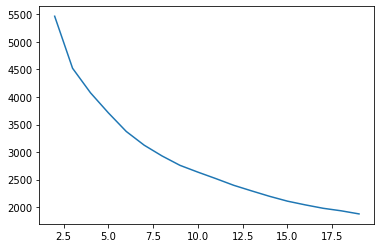

In [28]:
plt.plot(range(2, 20), inertia_values); # K = 3

In [29]:
kmeans = KMeans(n_clusters = 3, n_init = 100, max_iter = 500, copy_x = False)
kmeans.fit_transform(train[features])

array([[1.45776238, 3.25188637, 2.88542032],
       [3.75795147, 2.03421164, 4.20923063],
       [1.89172458, 3.18355936, 3.16197695],
       ...,
       [3.34706176, 4.46843718, 2.42696312],
       [2.87117162, 2.24994573, 4.07855735],
       [1.41225138, 3.14494331, 3.59888404]])

In [30]:
kmeans = KMeans(n_clusters = 3, n_init = 100, max_iter = 500, copy_x = False)
kmeans.fit_transform(train[features])
train[['cluster_0', 'cluster_1', 'cluster_2']] =  pd.get_dummies(kmeans.labels_)

kmeans.transform(test[features])
test[['cluster_0', 'cluster_1', 'cluster_2']] =  pd.get_dummies(kmeans.predict(test[features]))

features = [col for col in train.columns if col not in ['Survived', 'PassengerId']]

# Base Models

## Light GBM

In [39]:
import lightgbm as lgb

def objective(trial):
    
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 32),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    kf = KFold(5, shuffle = True, random_state = 0)
    kf.split(train)
    
    accuracy_scores = []
    
    for train_ix, test_ix in kf.split(train):
        dtrain = lgb.Dataset(train.loc[train_ix, features], label = train.loc[train_ix, 'Survived'])
        
        gbm = lgb.train(param, dtrain)
        preds = np.rint(gbm.predict(train.loc[test_idx, features]))
        
        accuracy_scores.append(metrics.accuracy_score(train.loc[test_idx, 'Survived'], preds))
        
    return np.mean(accuracy_scores)
    

# # 3. Create a study object and optimize the objective function.
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=250)

[I 2021-12-22 20:32:16,604] A new study created in memory with name: no-name-1c93899d-52b3-42b8-9986-576f3cb2ecae
[I 2021-12-22 20:32:16,749] Trial 0 finished with value: 0.7991400414286611 and parameters: {'lambda_l1': 6.392971348352724e-05, 'lambda_l2': 8.041081404686387e-06, 'num_leaves': 12, 'feature_fraction': 0.8070143672569244, 'bagging_fraction': 0.5115606779832345, 'bagging_freq': 3, 'min_child_samples': 99}. Best is trial 0 with value: 0.7991400414286611.
[I 2021-12-22 20:32:17,141] Trial 1 finished with value: 0.8170296905404557 and parameters: {'lambda_l1': 3.586253714155974e-06, 'lambda_l2': 1.13862644784498e-06, 'num_leaves': 26, 'feature_fraction': 0.5920360716926122, 'bagging_fraction': 0.9035854363156637, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 1 with value: 0.8170296905404557.
[I 2021-12-22 20:32:17,314] Trial 2 finished with value: 0.8114242671520934 and parameters: {'lambda_l1': 5.640440536737402e-07, 'lambda_l2': 1.4548293634879116e-05, 'num_leav

[I 2021-12-22 20:32:22,009] Trial 22 finished with value: 0.8361245370660975 and parameters: {'lambda_l1': 0.4200701590618177, 'lambda_l2': 7.258153852794407e-05, 'num_leaves': 29, 'feature_fraction': 0.9288240879430438, 'bagging_fraction': 0.9823302217824006, 'bagging_freq': 4, 'min_child_samples': 47}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:32:22,281] Trial 23 finished with value: 0.8305065595380077 and parameters: {'lambda_l1': 0.4443838703995051, 'lambda_l2': 0.22340011714082872, 'num_leaves': 22, 'feature_fraction': 0.9286377268362842, 'bagging_fraction': 0.9647155759002808, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:32:22,536] Trial 24 finished with value: 0.8237838177138912 and parameters: {'lambda_l1': 1.2217240438298846, 'lambda_l2': 0.002463640103280921, 'num_leaves': 28, 'feature_fraction': 0.8456750101979462, 'bagging_fraction': 0.9604131326250278, 'bagging_freq': 4, 'min_child_sa

[I 2021-12-22 20:32:28,289] Trial 45 finished with value: 0.8316301550436258 and parameters: {'lambda_l1': 0.19788020288499356, 'lambda_l2': 0.0002915495346126681, 'num_leaves': 29, 'feature_fraction': 0.690705008742354, 'bagging_fraction': 0.9353724702785845, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:32:28,523] Trial 46 finished with value: 0.8271608813006089 and parameters: {'lambda_l1': 0.014357787173627325, 'lambda_l2': 0.00010896688224121842, 'num_leaves': 25, 'feature_fraction': 0.9498957538318763, 'bagging_fraction': 0.7655229308337063, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:32:28,849] Trial 47 finished with value: 0.821542903772519 and parameters: {'lambda_l1': 1.107717719258114e-05, 'lambda_l2': 1.6234388712953834e-05, 'num_leaves': 27, 'feature_fraction': 0.8529909584432215, 'bagging_fraction': 0.8456982014729227, 'bagging_freq': 5, 'min

[I 2021-12-22 20:32:34,113] Trial 68 finished with value: 0.8237775406440274 and parameters: {'lambda_l1': 0.004670090636570892, 'lambda_l2': 1.59052769245356e-07, 'num_leaves': 18, 'feature_fraction': 0.8297637914276058, 'bagging_fraction': 0.9530282046847264, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:32:34,364] Trial 69 finished with value: 0.832772581758835 and parameters: {'lambda_l1': 0.008095474646872571, 'lambda_l2': 5.077386409490682e-06, 'num_leaves': 14, 'feature_fraction': 0.6764838120463884, 'bagging_fraction': 0.9221408818808012, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:32:34,601] Trial 70 finished with value: 0.8215303496327915 and parameters: {'lambda_l1': 0.019590666217987537, 'lambda_l2': 2.303774678986589e-05, 'num_leaves': 7, 'feature_fraction': 0.6369873866820246, 'bagging_fraction': 0.9833622353471669, 'bagging_freq': 5, 'min_ch

[I 2021-12-22 20:32:40,058] Trial 91 finished with value: 0.8305128366078716 and parameters: {'lambda_l1': 2.3928233696775014e-05, 'lambda_l2': 3.9209572322883005e-05, 'num_leaves': 21, 'feature_fraction': 0.6265413254410475, 'bagging_fraction': 0.9559185973390645, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:32:40,334] Trial 92 finished with value: 0.8271608813006088 and parameters: {'lambda_l1': 5.9256661053465985e-05, 'lambda_l2': 4.598110065403515e-06, 'num_leaves': 23, 'feature_fraction': 0.5448188151503046, 'bagging_fraction': 0.9151544655549616, 'bagging_freq': 4, 'min_child_samples': 45}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:32:40,576] Trial 93 finished with value: 0.8305191136777352 and parameters: {'lambda_l1': 1.1184839855199119e-05, 'lambda_l2': 0.0006297518332193255, 'num_leaves': 22, 'feature_fraction': 0.6628553775433524, 'bagging_fraction': 0.944231428821731, 'bagging_freq': 4

[I 2021-12-22 20:32:46,244] Trial 114 finished with value: 0.8260498399347185 and parameters: {'lambda_l1': 0.0009969959000598687, 'lambda_l2': 9.007014884141505e-05, 'num_leaves': 13, 'feature_fraction': 0.676586223051265, 'bagging_fraction': 0.8975084824279764, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:32:46,500] Trial 115 finished with value: 0.826037285794991 and parameters: {'lambda_l1': 0.1740600076616413, 'lambda_l2': 4.970639135883205e-05, 'num_leaves': 13, 'feature_fraction': 0.6237990809016247, 'bagging_fraction': 0.8692541414343299, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:32:46,773] Trial 116 finished with value: 0.8338899001945892 and parameters: {'lambda_l1': 0.04913897716242935, 'lambda_l2': 9.635858888110788e-06, 'num_leaves': 11, 'feature_fraction': 0.7024436131963749, 'bagging_fraction': 0.955184610086501, 'bagging_freq': 6, 'min_c

[I 2021-12-22 20:32:52,388] Trial 137 finished with value: 0.8237775406440274 and parameters: {'lambda_l1': 0.17120683692142855, 'lambda_l2': 0.00013957222508214373, 'num_leaves': 21, 'feature_fraction': 0.9658824185986019, 'bagging_fraction': 0.9909543629928306, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:32:52,655] Trial 138 finished with value: 0.8305128366078713 and parameters: {'lambda_l1': 0.008854407588337906, 'lambda_l2': 9.68911327558091e-06, 'num_leaves': 23, 'feature_fraction': 0.6581268399725917, 'bagging_fraction': 0.9630387641829684, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:32:52,928] Trial 139 finished with value: 0.8293892411022536 and parameters: {'lambda_l1': 0.5137074884367819, 'lambda_l2': 2.940767346465521e-06, 'num_leaves': 12, 'feature_fraction': 0.9032246145161328, 'bagging_fraction': 0.9773495069450313, 'bagging_freq': 5, 'min

[I 2021-12-22 20:32:58,521] Trial 160 finished with value: 0.8237775406440273 and parameters: {'lambda_l1': 0.21590426350745634, 'lambda_l2': 7.591097993379233e-06, 'num_leaves': 28, 'feature_fraction': 0.6014419067186153, 'bagging_fraction': 0.9087818666412456, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:32:58,779] Trial 161 finished with value: 0.8316489862532169 and parameters: {'lambda_l1': 0.12372634120992791, 'lambda_l2': 1.2877944491999885e-05, 'num_leaves': 30, 'feature_fraction': 0.9076549183932004, 'bagging_fraction': 0.8345111561561149, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:32:59,039] Trial 162 finished with value: 0.8271671583704727 and parameters: {'lambda_l1': 0.3729002193740656, 'lambda_l2': 2.1432900337803034e-05, 'num_leaves': 28, 'feature_fraction': 0.8792503698264691, 'bagging_fraction': 0.8665102264359231, 'bagging_freq': 6, 'mi

[I 2021-12-22 20:33:04,675] Trial 183 finished with value: 0.8137028435126483 and parameters: {'lambda_l1': 0.058339653020666175, 'lambda_l2': 0.00039692050612386714, 'num_leaves': 27, 'feature_fraction': 0.7406393110276931, 'bagging_fraction': 0.9792801936172691, 'bagging_freq': 3, 'min_child_samples': 99}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:33:04,956] Trial 184 finished with value: 0.8293892411022534 and parameters: {'lambda_l1': 0.5272388142667611, 'lambda_l2': 0.0038844727261595057, 'num_leaves': 24, 'feature_fraction': 0.9219223547583201, 'bagging_fraction': 0.9275668995157118, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:33:05,232] Trial 185 finished with value: 0.8372606867114432 and parameters: {'lambda_l1': 0.03927538584025035, 'lambda_l2': 0.0008060611578088183, 'num_leaves': 23, 'feature_fraction': 0.7041819762119532, 'bagging_fraction': 0.9874678077120393, 'bagging_freq': 3, 'mi

[I 2021-12-22 20:33:10,974] Trial 206 finished with value: 0.8260184545853996 and parameters: {'lambda_l1': 0.06465715004150269, 'lambda_l2': 0.0005284502993165734, 'num_leaves': 11, 'feature_fraction': 0.6831882005812279, 'bagging_fraction': 0.9876937628975584, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:33:11,245] Trial 207 finished with value: 0.8282593685267716 and parameters: {'lambda_l1': 0.31088185809295593, 'lambda_l2': 0.0013600416900314157, 'num_leaves': 12, 'feature_fraction': 0.6588323325368437, 'bagging_fraction': 0.9451329962974294, 'bagging_freq': 4, 'min_child_samples': 51}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:33:11,542] Trial 208 finished with value: 0.8338773460548616 and parameters: {'lambda_l1': 0.016547771712497095, 'lambda_l2': 3.5887417727481244e-06, 'num_leaves': 27, 'feature_fraction': 0.663093791645384, 'bagging_fraction': 0.9572180411515862, 'bagging_freq': 4, 'mi

[I 2021-12-22 20:33:17,321] Trial 229 finished with value: 0.8350072186303434 and parameters: {'lambda_l1': 0.2733063160217703, 'lambda_l2': 0.0032611009957854947, 'num_leaves': 27, 'feature_fraction': 0.754778875837993, 'bagging_fraction': 0.989528897201257, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:33:17,604] Trial 230 finished with value: 0.8316427091833531 and parameters: {'lambda_l1': 0.28653263580316085, 'lambda_l2': 0.003155863386592761, 'num_leaves': 27, 'feature_fraction': 0.7986080232967202, 'bagging_fraction': 0.973280301352641, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 21 with value: 0.8383654510074697.
[I 2021-12-22 20:33:17,887] Trial 231 finished with value: 0.8316364321134893 and parameters: {'lambda_l1': 0.20471229009701405, 'lambda_l2': 0.0022423771306299815, 'num_leaves': 26, 'feature_fraction': 0.7467206740343227, 'bagging_fraction': 0.9864631850625143, 'bagging_freq': 5, 'min_chil

In [48]:
plot_optimization_history(study)

In [46]:
plot_parallel_coordinate(study)

In [50]:
'''
{'lambda_l1': 0.23983706945898253,
 'lambda_l2': 8.622237296912371e-05,
 'num_leaves': 29,
 'feature_fraction': 0.9144574800999573,
 'bagging_fraction': 0.9844533490969807,
 'bagging_freq': 4,
 'min_child_samples': 46}
 
 best_value = 0.8383654510074697
'''

best_params = {'lambda_l1': 0.23983706945898253,
 'lambda_l2': 8.622237296912371e-05,
 'num_leaves': 29,
 'feature_fraction': 0.9144574800999573,
 'bagging_fraction': 0.9844533490969807,
 'bagging_freq': 4,
 'min_child_samples': 46}

In [51]:
kf_stacking = KFold(4, shuffle = True, random_state = 0)
kf_stacking.split(train)

for train_ix, test_ix in kf_stacking.split(train):
    lgbm = lgb.train(best_params, 
        lgb.Dataset(train.loc[train_ix, features], label = train.loc[train_ix, 'Survived']))
    
    train.loc[test_ix,'lv1_lgbm_preds'] = lgbm.predict(train.loc[test_ix, features])
    

lgbm = lgb.train(best_params, lgb.Dataset(train[features], label = train['Survived']))

test['lv1_lgbm_preds'] = lgbm.predict(test[features])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 21
[LightGBM] [Info] Start training from score 0.386228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

F:\Python\Python37\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

## Grandient Boosting Machine

In [111]:
from sklearn.ensemble import GradientBoostingClassifier 

def objective(trial):
    
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-2)
    n_estimators = trial.suggest_int('n_estimators', 20, 200)
    subsample = trial.suggest_float('subsample', 0.75, 1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.75, 1)
    max_features = trial.suggest_int('max_features', 3, 20)
    
    gbm = GradientBoostingClassifier(learning_rate = learning_rate,
                                     n_estimators = n_estimators,
                                     subsample = subsample,
                                     min_samples_split = min_samples_split,
                                     min_samples_leaf = min_samples_leaf,
                                     max_depth = max_depth,
                                     min_impurity_decrease = min_impurity_decrease,
                                     random_state = 42,
                                     max_features = max_features)
    
    kf = KFold(5, shuffle = True, random_state = 0)
    kf.split(train)
    
    accuracy_scores = []
    
    for train_ix, test_ix in kf.split(train):
        gbm.fit(train.loc[train_ix, features], train.loc[train_ix, 'Survived'])
        preds = np.rint(gbm.predict(train.loc[test_ix, features]))
        
        accuracy_scores.append(metrics.accuracy_score(train.loc[test_ix, 'Survived'], preds))
        
    return np.mean(accuracy_scores)
    

# 3. Create a study object and optimize the objective function.

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2021-12-22 21:37:02,278] A new study created in memory with name: no-name-9a018de0-d597-4605-bf0f-d6704a0fd68a
[I 2021-12-22 21:37:02,810] Trial 0 finished with value: 0.7867114430983617 and parameters: {'learning_rate': 0.005296672154483834, 'n_estimators': 125, 'subsample': 0.9555220718330827, 'min_samples_split': 7, 'min_samples_leaf': 20, 'max_depth': 3, 'min_impurity_decrease': 0.9806330321044527, 'max_features': 11}. Best is trial 0 with value: 0.7867114430983617.
[I 2021-12-22 21:37:03,476] Trial 1 finished with value: 0.8024543343167408 and parameters: {'learning_rate': 0.005704183216093639, 'n_estimators': 173, 'subsample': 0.7887468022543601, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_depth': 6, 'min_impurity_decrease': 0.920120248785882, 'max_features': 5}. Best is trial 1 with value: 0.8024543343167408.
[I 2021-12-22 21:37:04,198] Trial 2 finished with value: 0.8148138848785388 and parameters: {'learning_rate': 0.009264509332578557, 'n_estimators': 186, 'subsam

KeyboardInterrupt: 

In [ ]:
'''
learning_rate = 0.009620110160365543,
n_estimators = 135,
subsample = 0.9699332268604093,
min_samples_split = 12,
min_samples_leaf = 2,
max_depth = 7,
min_impurity_decrease = 0.7763728807219239,
max_features = 20,
random_state = 42
'''

In [74]:
kf_stacking = KFold(4, shuffle = True, random_state = 0)

train['lv1_gbm_preds'] = np.nan
for train_ix, test_ix in kf_stacking.split(train):
    gbm = GradientBoostingClassifier(
        learning_rate = 0.009620110160365543,
        n_estimators = 135,
        subsample = 0.9699332268604093,
        min_samples_split = 12,
        min_samples_leaf = 2,
        max_depth = 7,
        min_impurity_decrease = 0.7763728807219239,
        max_features = 20,
        random_state = 42)
    
    gbm.fit(train.loc[train_ix, features], train.loc[train_ix, 'Survived'])
    train.loc[test_ix,'lv1_gbm_preds'] = gbm.predict(train[features].iloc[test_ix])    
    
gbm.fit(train[features], train['Survived'])
test['lv1_gbm_preds'] = gbm.predict(test[features])

GradientBoostingClassifier(learning_rate=0.009620110160365543, max_depth=7,
                           max_features=20,
                           min_impurity_decrease=0.7763728807219239,
                           min_samples_leaf=2, min_samples_split=12,
                           n_estimators=135, random_state=42,
                           subsample=0.9699332268604093)

## SVM

In [76]:
from sklearn.svm import SVC

def objective(trial):
    
    svc = SVC(C = trial.suggest_float('C', 1e-6, 10))
    
    kf = KFold(5, shuffle = True, random_state = 0)
    kf.split(train)
    
    accuracy_scores = []
    
    for train_ix, test_ix in kf.split(train):
        svc.fit(train.loc[train_ix,features], train.loc[train_ix, 'Survived'])
        preds = svc.predict(train.loc[test_ix,features])
        
        accuracy_scores.append(metrics.accuracy_score(train.loc[test_ix, 'Survived'], preds))
        
    return np.mean(accuracy_scores)
    

# 3. Create a study object and optimize the objective function.
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=1000)

In [ ]:
'''
C = 0.4898842008006796
'''

In [78]:
kf_stacking = KFold(4, shuffle = True, random_state = 0)

for train_ix, test_ix in kf_stacking.split(train):
    svc = SVC(C = 0.4898842008006796)
    
    svc.fit(train.loc[train_ix,features], train.loc[train_ix,'Survived'])
    train.loc[test_ix,'lv1_svc_preds'] = svc.predict(train.loc[test_ix, features]) 
    
svc.fit(train[features], train['Survived'])
test['lv1_svc_preds'] = svc.predict(test[features])

## Random Forest

In [80]:
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    
    rf = RandomForestClassifier(
        n_estimators = trial.suggest_int('n_estimators', 10, 250),
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']),
        max_depth = trial.suggest_int('max_depth', 3, 12),
        min_samples_split = trial.suggest_float('min_samples_split', 0, 1),
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25), 
        max_features = trial.suggest_int('max_features', 1, 25),
        max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 200),
        random_state = 0
    )
    
    
    kf = KFold(5, shuffle = True, random_state = 0)
    kf.split(train)
    
    accuracy_scores = []
    
    for train_ix, test_ix in kf.split(train):
        rf.fit(train.loc[train_ix, features], train.loc[train_ix, 'Survived'])
        preds = rf.predict(train.loc[test_idx, features])
        
        accuracy_scores.append(metrics.accuracy_score(train.loc[test_idx, 'Survived'], preds))
        
    return np.mean(accuracy_scores)
    

# 3. Create a study object and optimize the objective function.

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=1000)

In [ ]:
'''
{'n_estimators': 82,
  'criterion': 'entropy',
  'max_depth': 9,
  'min_samples_split': 8.96842165215019e-05,
  'min_samples_leaf': 1,
  'max_features': 19,
  'max_leaf_nodes': 192}
''' 

In [116]:
kf_stacking = KFold(4, shuffle = True, random_state = 0)

for train_ix, test_ix in kf_stacking.split(train):
    rf = RandomForestClassifier(
        n_estimators = 82,
        criterion = 'entropy',
        max_depth = 9,
        min_samples_split = 8.96842165215019e-05,
        min_samples_leaf = 1,
        max_features = 19,
        max_leaf_nodes = 192,
        random_state = 0
    )
    
    rf.fit(train.loc[train_ix,features], train.loc[train_ix,'Survived'])
    train.loc[test_ix,'lv1_rf_preds'] = rf.predict(train.loc[test_ix, features]) 
    
rf.fit(train[features], train['Survived'])
test['lv1_rf_preds'] = rf.predict(test[features])

## Logistic Regression

In [114]:
from sklearn.linear_model import LogisticRegression

def objective(trial):
    
    logit = LogisticRegression(
        penalty = 'elasticnet',
        C = trial.suggest_float('C', 1, 100, log = True),
        l1_ratio = trial.suggest_float('l1_ratio', 0, 1),
        solver = 'saga',
        max_iter = 10000,
        random_state = 0
    )
    
    
    kf = KFold(5, shuffle = True, random_state = 0)
    kf.split(train)
    
    accuracy_scores = []

    for train_ix, test_ix in kf.split(train):
        logit.fit(train.loc[train_ix, features], train.loc[train_ix, 'Survived'])
        preds = logit.predict(train.loc[test_ix, features])
        
        
        accuracy_scores.append(metrics.accuracy_score(train.loc[test_ix, 'Survived'], preds))
        
    return np.mean(accuracy_scores)
    

# 3. Create a study object and optimize the objective function.

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

[I 2021-12-22 21:51:02,518] A new study created in memory with name: no-name-1a5a963d-f0f6-4368-8209-d4d79ca77e07
[I 2021-12-22 21:51:04,122] Trial 0 finished with value: 0.813709120582512 and parameters: {'C': 15.118174963261461, 'l1_ratio': 0.5854510710638687}. Best is trial 0 with value: 0.813709120582512.
[I 2021-12-22 21:51:05,912] Trial 1 finished with value: 0.8125855250768941 and parameters: {'C': 6.367143699118766, 'l1_ratio': 0.1992294398486285}. Best is trial 0 with value: 0.813709120582512.
[I 2021-12-22 21:51:09,572] Trial 2 finished with value: 0.813709120582512 and parameters: {'C': 98.88329774808986, 'l1_ratio': 0.14761603646854204}. Best is trial 0 with value: 0.813709120582512.
[I 2021-12-22 21:51:11,427] Trial 3 finished with value: 0.8125855250768941 and parameters: {'C': 8.830611022046414, 'l1_ratio': 0.17887043267848335}. Best is trial 0 with value: 0.813709120582512.
[I 2021-12-22 21:51:14,552] Trial 4 finished with value: 0.813709120582512 and parameters: {'C': 

KeyboardInterrupt: 

In [ ]:
'''  
best_score = 
''' 

In [117]:
kf_stacking = KFold(4, shuffle = True, random_state = 0)

for train_ix, test_ix in kf_stacking.split(train):
    logit = LogisticRegression()
    
    logit.fit(train.loc[train_ix,features], train.loc[train_ix,'Survived'])
    train.loc[test_ix,'lv1_logit_preds'] = logit.predict(train.loc[test_ix, features]) 
    
logit.fit(train[features], train['Survived'])
test['lv1_logit_preds'] = logit.predict(test[features])

In [93]:
submission['Survived']

0      0
1      0
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    0
Name: Survived, Length: 418, dtype: int32

In [148]:
lv1_preds = [col for col in train.columns if col not in features if col not in ['Survived', 'PassengerId']]

In [149]:
from sklearn.model_selection import cross_validate
logit = LogisticRegression()

cv = cross_validate(logit, train[lv1_preds], train['Survived'], scoring = "accuracy", cv = 3)
cv['test_score'].mean()

0.8350168350168349

In [150]:
submission = pd.read_csv('data/submission.csv')

In [152]:
logit.fit(train[lv1_preds], train['Survived'])

submission['Survived'] = logit.predict(test[lv1_preds])

In [155]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.9)

In [159]:
features = [col for col in train.columns if col not in ['Survived', 'PassengerId']]

In [172]:
new_train_df = pd.concat([train['Survived'], pd.DataFrame(pca.fit_transform(train[features]))], axis = 1)
new_test_df = pd.DataFrame(pca.transform(test[features]))

In [179]:
new_train_df.columns = ['Survived', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']

In [183]:
logit.fit(new_train_df.drop('Survived', axis = 1), new_train_df['Survived'])

LogisticRegression()

In [181]:
new_test_df.columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']

In [184]:
submission['Survived'] = logit.predict(new_test_df)

In [185]:
submission.to_csv("data/submission.csv", index = False)

In [186]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0


In [65]:
lgbm = lgb.train({
    'lambda_l1': 3.0382509030081943e-07,
    'lambda_l2': 1.7528164440749284e-06,
    'num_leaves': 28,
    'feature_fraction': 0.7757503939389271,
    'bagging_fraction': 0.6778524391467955,
    'bagging_freq': 1,
    'min_child_samples': 42}, 
    lgb.Dataset(train[features], label = train['Survived']))

submission['Survived'] =  np.abs(np.rint(lgbm.predict(test[features])))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 23
[LightGBM] [Info] Start training from score 0.383838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [67]:
submission.to_csv("data/submission.csv", index = False)

In [68]:
submission

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0
